In [1]:
import tensorflow as tf
import numpy as np
import glob
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from deeplab import MY_MODEL
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, LearningRateScheduler
%matplotlib inline

2024-03-10 12:33:46.980389: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 12:33:47.771851: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
img = glob.glob('./images/train/*/*.png')
label = [path.replace('images', 'gtFine').replace('_leftImg8bit.png', '_gtFine_labelTrainIds.png') for path in img]

index = np.random.permutation(len(img))
img = np.array(img)[index]
label = np.array(label)[index]

img_val = glob.glob('./images/val/*/*.png')
label_val = [path.replace('images', 'gtFine').replace('_leftImg8bit.png', '_gtFine_labelTrainIds.png') for path in img_val]

train_count = len(label)
val_count = len(label_val)

dataset_train = tf.data.Dataset.from_tensor_slices((img, label))
dataset_val = tf.data.Dataset.from_tensor_slices((img_val, label_val))

2024-03-10 12:33:49.068923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-10 12:33:49.082260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-10 12:33:49.082498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

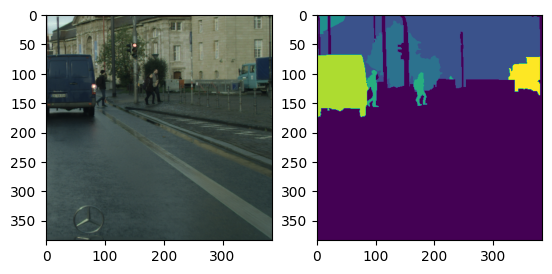

In [3]:
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img

def read_png_label(path):
    with tf.device('/cpu:0'): 
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=1)
        img = tf.where(img == 255, tf.zeros_like(img), img)
    return img

def crop_img(img, mask):

    # 确保float32类型
    img_uint8 = tf.cast(img, tf.uint8)

    concat_img = tf.concat([img_uint8, mask], axis=-1)
    concat_img = tf.image.resize(concat_img, (512, 1024), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    crop_img = tf.image.random_crop(concat_img, [384, 384, tf.shape(concat_img)[-1]])

    # 将裁剪后的图像和掩码分离，并将掩码转换回原始数据类型
    return crop_img[:, :, :3], tf.cast(crop_img[:, :, 3:], mask.dtype)



img_1 = read_png(img[0])
label_1 = read_png_label(label[0])
concat_img = tf.concat([img_1, label_1], axis=-1)
img_1, label_1 = crop_img(img_1, label_1)

plt.subplot(1,2,1)
plt.imshow(img_1.numpy())
plt.subplot(1,2,2)
plt.imshow(np.squeeze(label_1.numpy()))

In [4]:
def normal(img, mask):
    img = tf.cast(img, tf.float32)/127.5 -1
    mask = tf.cast(mask, tf.int32)
    return img, mask


# def apply_sobel_filter(image, enhancement_factor=1.0):
#     # 将 TensorFlow 的 tensor 转换为 numpy 数组
#     image_np = image.numpy()
#     gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
#     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
#     sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
#     sobel = np.sqrt(sobelx**2 + sobely**2)
    
#     # 将 Sobel 边缘强度标准化到 [0, 255] 范围
#     sobel_normalized = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX)
    
#     # 调整 Sobel 边缘强度以控制增强效果
#     sobel_adjusted = sobel_normalized * enhancement_factor
    
#     # 将 numpy 数组转换回 TensorFlow 的 tensor
#     sobel_tensor = tf.convert_to_tensor(sobel_adjusted, dtype=tf.float32)
    
#     # 将 Sobel 边缘图像调整为与输入图像相同的维度
#     sobel_tensor_resized = tf.image.resize(sobel_tensor[..., tf.newaxis], [image.shape[0], image.shape[1]])
    
#     # 归一化
#     return sobel_tensor_resized / 255.0

def load_image_train(img_path, mask_path):
    img = read_png(img_path)
    mask = read_png_label(mask_path)
    
    img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
    img = tf.image.random_hue(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
    img = tf.clip_by_value(img, 0, 255)
    
    # 随机缩放
    scale = tf.random.uniform([], 0.7, 2)
    new_height = tf.cast(tf.cast(tf.shape(img)[0], tf.float32) * scale, tf.int32)
    new_width = tf.cast(tf.cast(tf.shape(img)[1], tf.float32) * scale, tf.int32)
    img = tf.image.resize(img, [new_height, new_width])
    mask = tf.image.resize(mask, [new_height, new_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    img, mask = crop_img(img, mask)
    
    # 随机水平翻转
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
        
    # img = tf.py_function(func=apply_sobel_filter, inp=[img], Tout=tf.float32)

    # 标准化
    img, mask = normal(img, mask)

    return img, mask


def load_image_val(img_path, mask_path):
    img = read_png(img_path)
    mask = read_png_label(mask_path)
    
    img, mask = crop_img(img, mask)
        
    img, mask = normal(img, mask)
    
    return img, mask

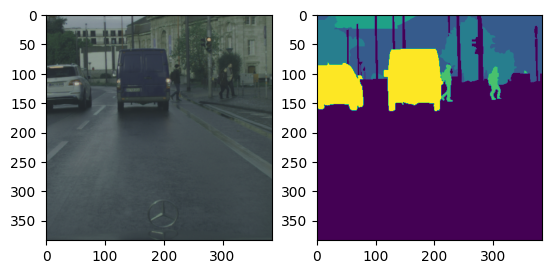

In [5]:
BCTCH_SIZE = 24
BUFFER_SIZE = 128
step_per_epoch = train_count//BCTCH_SIZE
val_step = val_count//BCTCH_SIZE

auto = tf.data.experimental.AUTOTUNE
dataset_train = dataset_train.map(load_image_train, num_parallel_calls=auto)
dataset_val = dataset_val.map(load_image_val, num_parallel_calls=auto)

for i, m in dataset_train.take(1):
    plt.subplot(1,2,1)
    plt.imshow((i.numpy() + 1)/2)
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(m.numpy()))

dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BCTCH_SIZE)
dataset_val = dataset_val.batch(BCTCH_SIZE)

In [6]:
dataset_train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 384, 384, 1), dtype=tf.int32, name=None))>

In [7]:
model = MY_MODEL(384, 384, 11)

*** Building MY_MODEL Network ***


/home/featurize/data/model/resnet/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


*** Output_Shape => (None, 384, 384, 11) ***


In [8]:
model.summary()

Model: "DeepLabV3_Plus"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384, 384, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 390, 390, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1 (Conv2D)              (None, 192, 192, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 192, 192, 64)         256       ['conv1[0][0]']               
 on)                                                                                 

In [9]:
# for layer in model.layers:
#     if isinstance(layer, tf.keras.layers.BatchNormalization):
#         layer.momentum = 0.9997
#     elif isinstance(layer, tf.keras.layers.Conv2D):
#         layer.kernel_regularizer = tf.keras.regularizers.l2(1e-4)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss', 
#     factor=0.1,         
#     patience=10,         
#     min_lr=0.000001,     
#     verbose=1
# )

In [10]:
# def softmax_dice_loss(y_true, y_pred_logits):
#     # Apply softmax to convert logits to probabilities
#     y_pred = tf.nn.softmax(y_pred_logits)
    
#     # Convert labels to one-hot encoding
#     y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    
#     # Define smooth term to avoid division by zero
#     smooth = 1e-6
    
#     # Initialize variable to accumulate loss
#     total_loss = 0.0
    
#     # Calculate Dice Loss for each class
#     for class_idx in range(y_pred.shape[-1]):
#         # Calculate intersection and union for the current class
#         y_true_class = y_true[..., class_idx]
#         y_pred_class = y_pred[..., class_idx]
        
#         # Remove the extra dimension from y_true_class
#         y_true_class = tf.squeeze(y_true_class, axis=-1)  # <-- This is the key line
        
#         intersection = tf.reduce_sum(y_true_class * y_pred_class)
#         union = tf.reduce_sum(y_true_class + y_pred_class)
        
#         # Compute Dice coefficient and subtract from 1 for loss
#         dice_coeff = (2. * intersection + smooth) / (union + smooth)
#         dice_loss = 1 - dice_coeff
        
#         # Accumulate loss
#         total_loss += dice_loss
    
#     # Average the loss across all classes
#     return total_loss / tf.cast(y_pred.shape[-1], tf.float32)

In [11]:
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
train_iou = MeanIoU(11, name='train_iou')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
test_iou = MeanIoU(11, name='test_iou')

In [12]:
base_learning_rate = 0.01
momentum = 0.9
weight_decay = 0.0001
power = 1.2
total_steps = 18550

# 使用多项式衰减学习率调度
learning_rate_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=base_learning_rate,
    decay_steps=total_steps,
    end_learning_rate=0.0, 
    power=power
)

class SGDW(tf.keras.optimizers.SGD):
    def __init__(self, weight_decay, *args, **kwargs):
        super(SGDW, self).__init__(*args, **kwargs)
        self.weight_decay = weight_decay

    def _resource_apply_dense(self, grad, var, apply_state=None):
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype)  # handle learning rate decay
        wd = lr_t * self.weight_decay

        var.assign_sub((lr_t * grad) + (wd * var))

optimizer = SGDW(
    weight_decay=weight_decay,
    learning_rate=learning_rate_schedule,
    momentum=momentum
)

In [13]:
train_losses = []
train_accuracies = []
train_ious = []
test_losses = []
test_accuracies = []
test_ious = []

def weight_decay_loss(model, weight_decay):
    # 计算所有可训练参数的L2损失
    l2_losses = [tf.nn.l2_loss(t) for t in model.trainable_variables if 'bias' not in t.name]
    # 将所有L2损失相加，并乘以权重衰减系数
    return weight_decay * tf.add_n(l2_losses)

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
        # 添加权重衰减损失
        loss += weight_decay_loss(model, weight_decay)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    train_iou(labels, predictions)

@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    test_iou(labels, predictions)

EPOCHS = 150

for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    train_iou.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    test_iou.reset_states()

    for images, labels in dataset_train:
        train_step(images, labels)

    for test_images, test_labels in dataset_val:
        test_step(test_images, test_labels)

    template = 'Epoch {:3d}, Loss: {:.3f}, Accuracy: {:.3f}, \
                IOU: {:.3f}, Test Loss: {:.3f}, \
                Test Accuracy: {:.3f}, Test IOU: {:.3f}'
    print (template.format(epoch+1,
                           train_loss.result(),
                           train_accuracy.result()*100,
                           train_iou.result(),
                           test_loss.result(),
                           test_accuracy.result()*100,
                           test_iou.result() 
                           ))
    train_losses.append(train_loss.result())
    train_accuracies.append(train_accuracy.result().numpy() * 100)
    train_ious.append(train_iou.result())
    test_losses.append(test_loss.result())
    test_accuracies.append(test_accuracy.result().numpy() * 100)
    test_ious.append(test_iou.result())

2024-03-10 12:34:17.409105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-10 12:34:20.046381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-10 12:34:21.565499: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-10 12:34:21.653786: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-10 12:34:21.653838: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0

Epoch   1, Loss: 2.467, Accuracy: 79.871,                 IOU: 0.362, Test Loss: 1.749,                 Test Accuracy: 51.638, Test IOU: 0.047
Epoch   2, Loss: 2.172, Accuracy: 86.846,                 IOU: 0.477, Test Loss: 1.604,                 Test Accuracy: 51.185, Test IOU: 0.048
Epoch   3, Loss: 2.136, Accuracy: 87.742,                 IOU: 0.506, Test Loss: 1.285,                 Test Accuracy: 57.462, Test IOU: 0.103
Epoch   4, Loss: 2.111, Accuracy: 88.438,                 IOU: 0.529, Test Loss: 0.914,                 Test Accuracy: 68.685, Test IOU: 0.232
Epoch   5, Loss: 2.095, Accuracy: 88.860,                 IOU: 0.550, Test Loss: 0.572,                 Test Accuracy: 79.518, Test IOU: 0.396
Epoch   6, Loss: 2.076, Accuracy: 89.280,                 IOU: 0.568, Test Loss: 0.377,                 Test Accuracy: 86.441, Test IOU: 0.514
Epoch   7, Loss: 2.059, Accuracy: 89.801,                 IOU: 0.579, Test Loss: 0.342,                 Test Accuracy: 87.346, Test IOU: 0.560

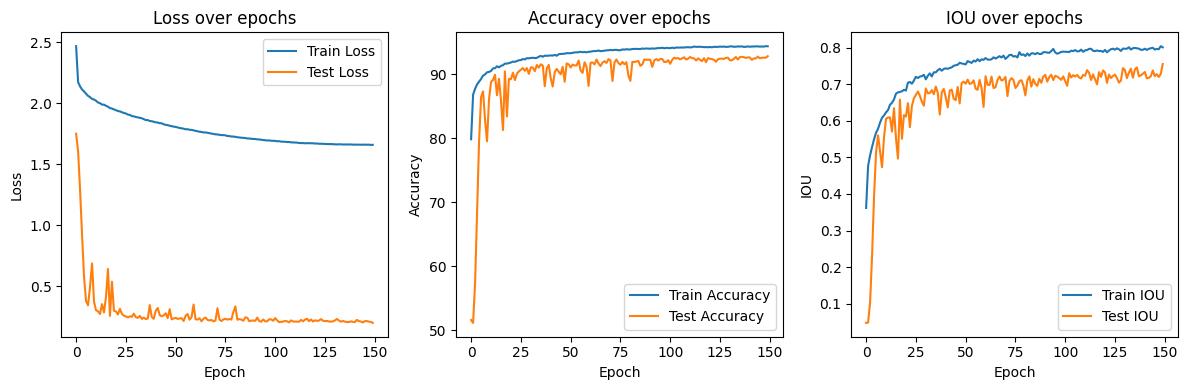

In [14]:
# 绘制训练和测试的损失图
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制训练和测试的准确率图
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 绘制训练和测试的IOU图
plt.subplot(1, 3, 3)
plt.plot(train_ious, label='Train IOU')
plt.plot(test_ious, label='Test IOU')
plt.title('IOU over epochs')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
model.save('my_model.h5') 

/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 140ms/step
Mean IoU:  0.74921584
Accuracy:  0.93079996
Precision:  0.95007914
Recall:  0.96098065


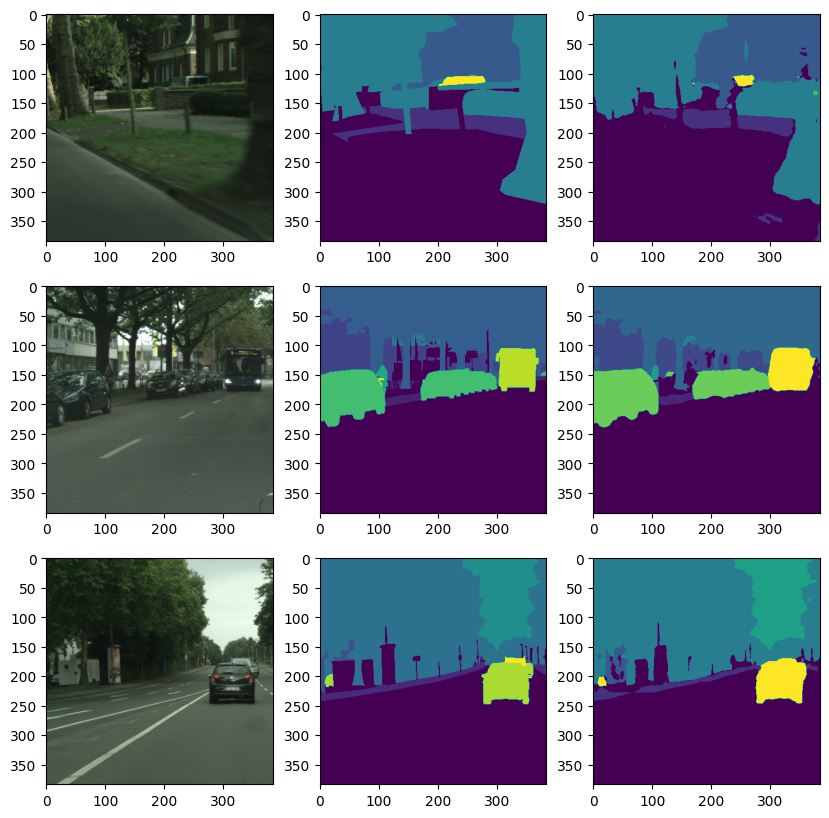

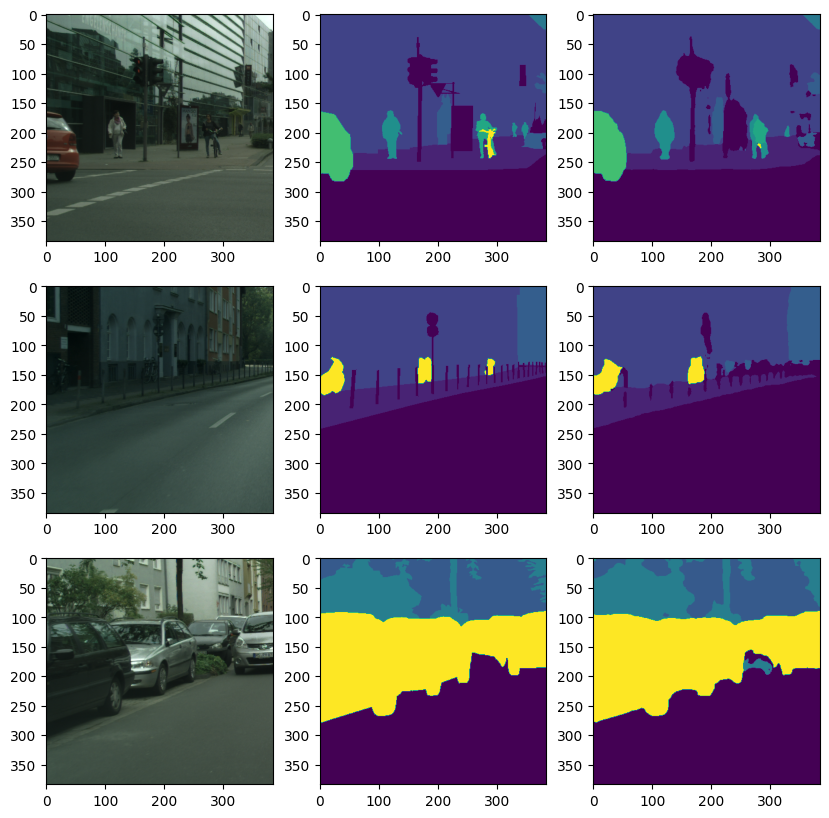

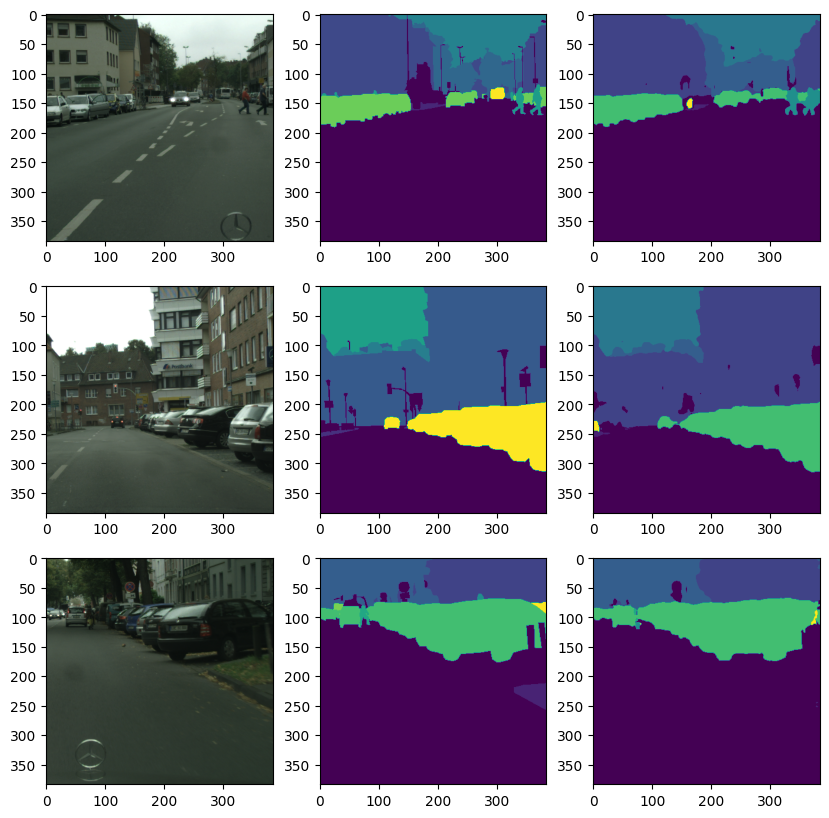

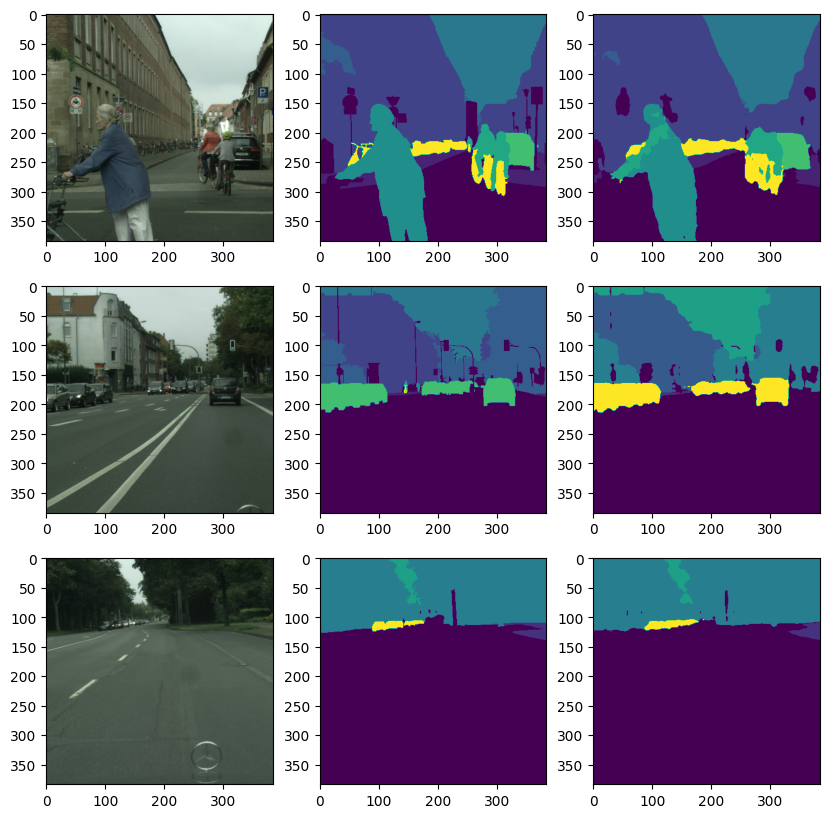

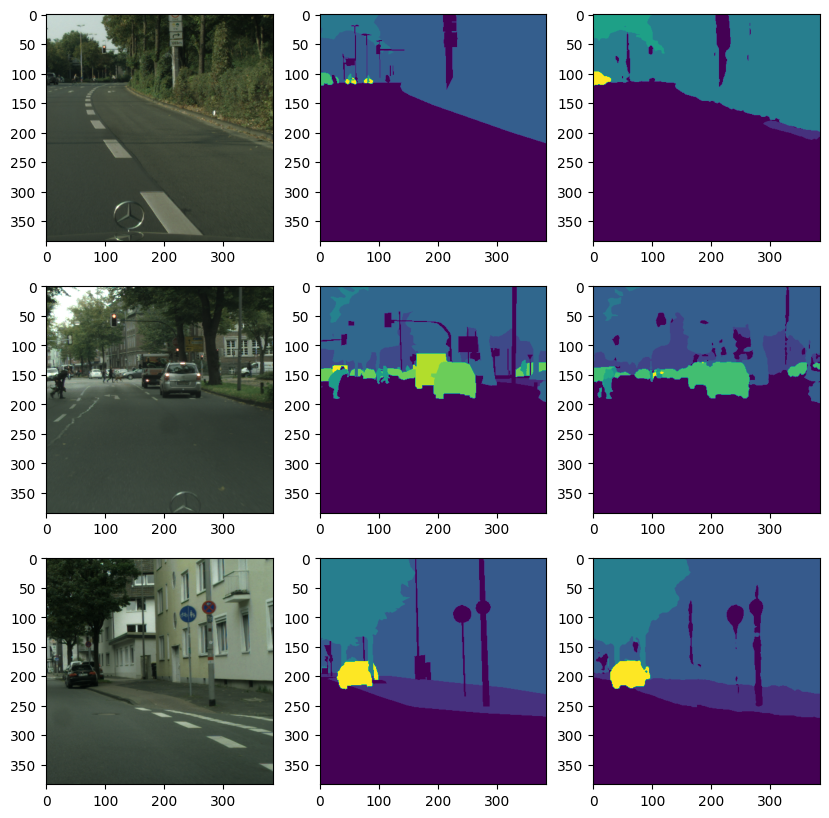

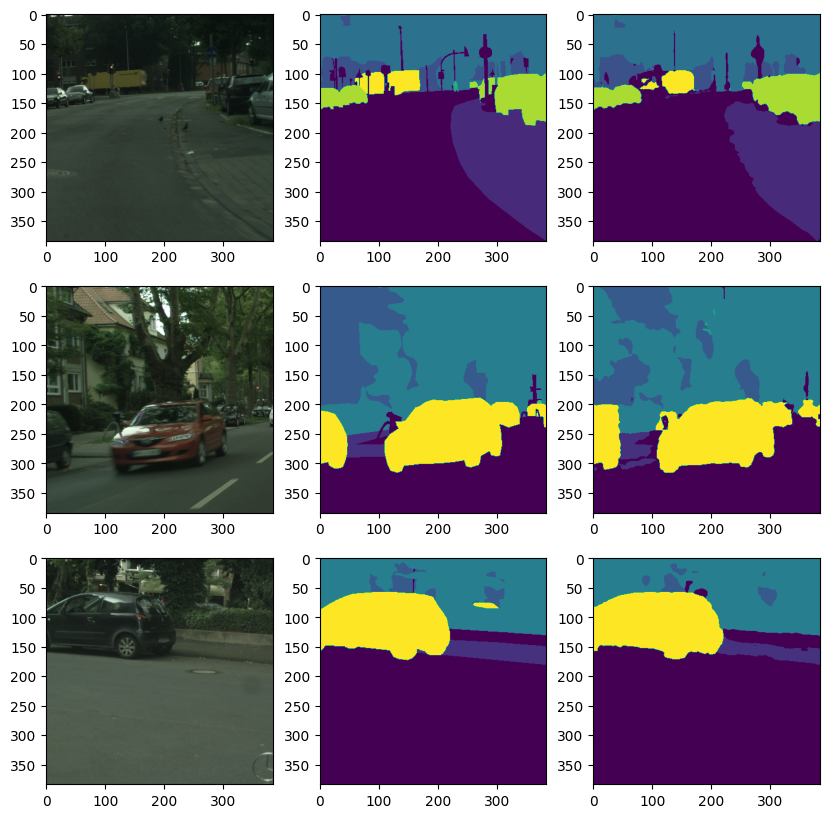

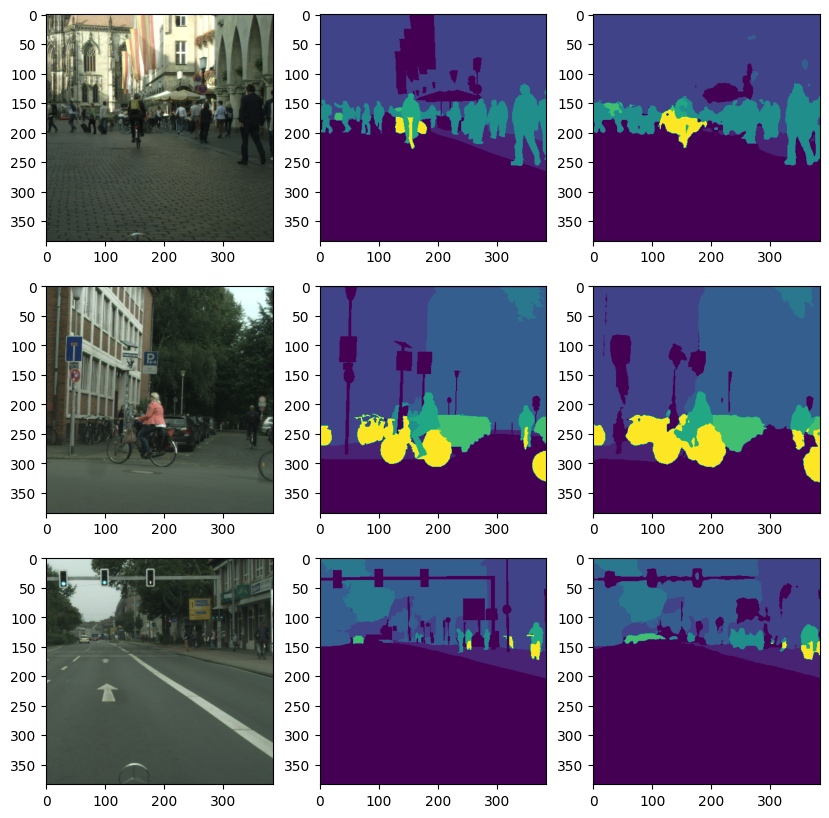

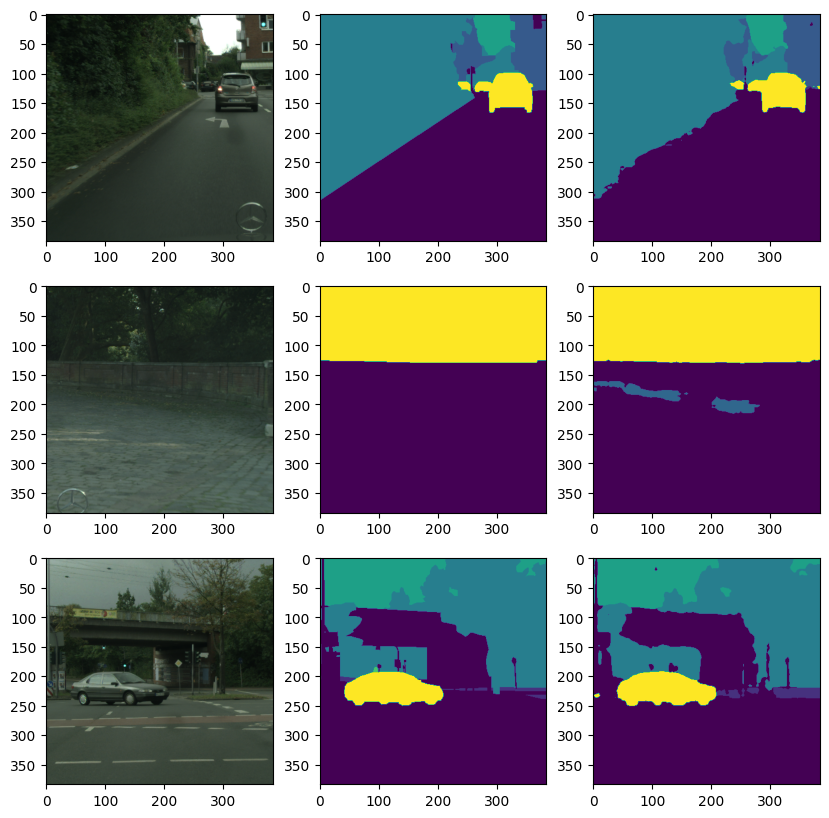

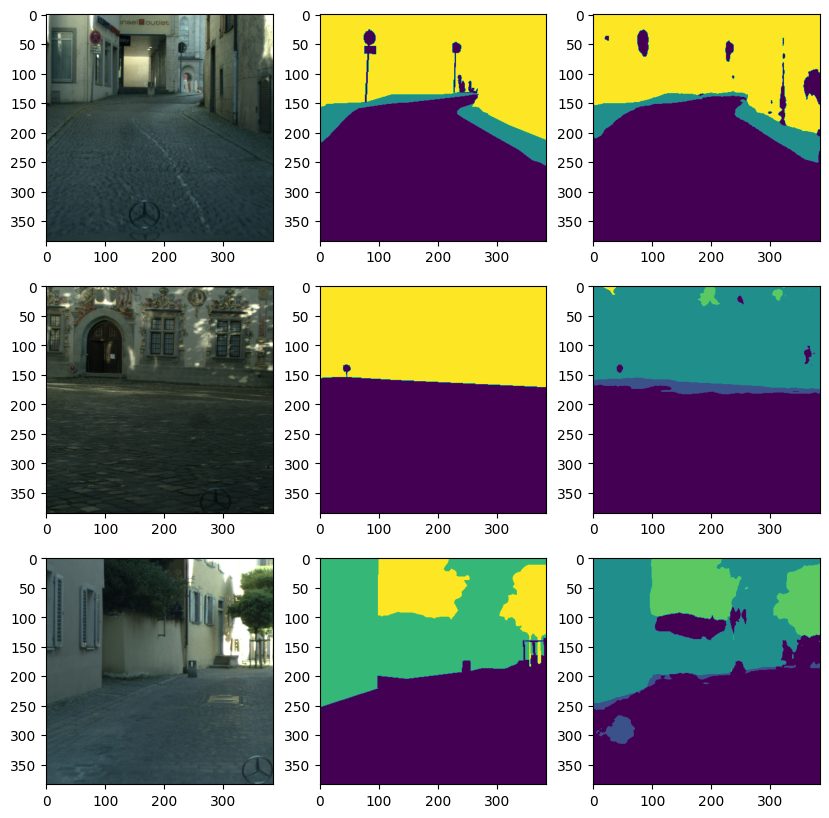

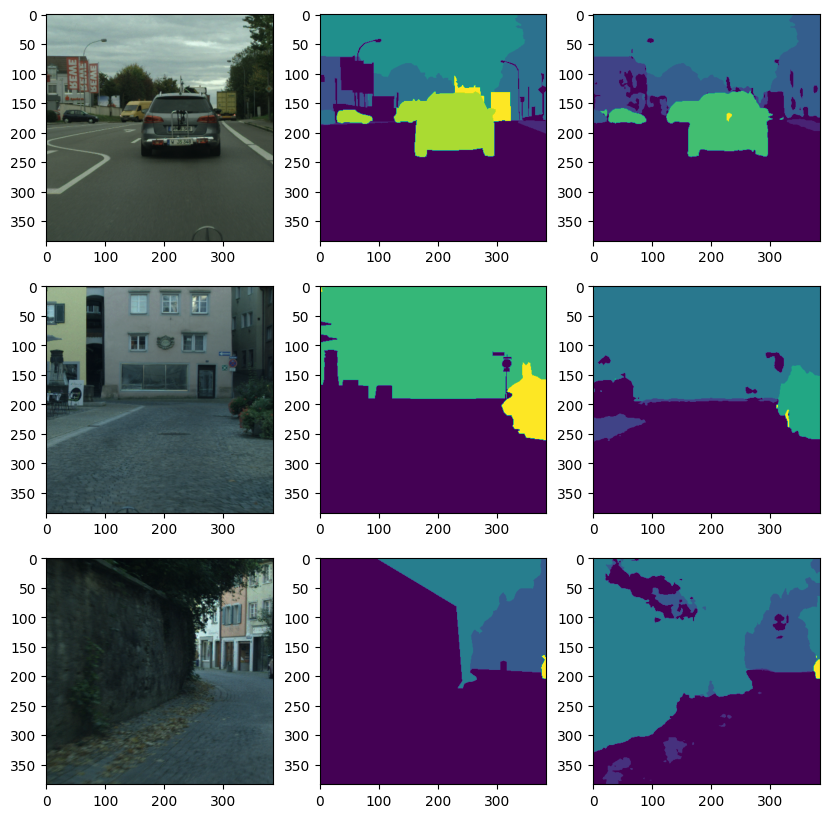

In [19]:
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.metrics import MeanIoU, Accuracy, Precision, Recall

miou_metric = MeanIoU(num_classes=11)
accuracy_metric = Accuracy()
precision_metric = Precision()
recall_metric = Recall()



model.save_weights('path_to_my_weights_final.h5')
model.load_weights('path_to_my_weights_final.h5')

num = 3
for image, mask in dataset_val.take(10):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    miou_metric.update_state(mask, pred_mask)
    accuracy_metric.update_state(mask, pred_mask)
    precision_metric.update_state(mask, pred_mask)
    recall_metric.update_state(mask, pred_mask)

    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))

miou = miou_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()

print("Mean IoU: ", miou)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

1/1 [==============================] - 0s 145ms/step
Mean IoU:  0.7773184
Accuracy:  0.9399985
Precision:  0.9535514
Recall:  0.96559316


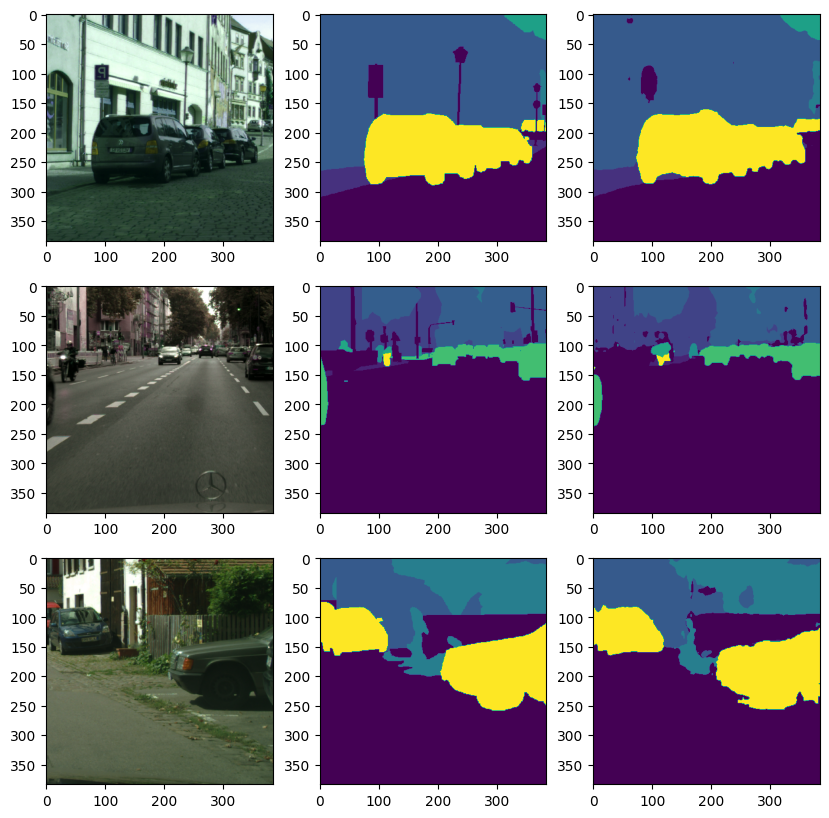

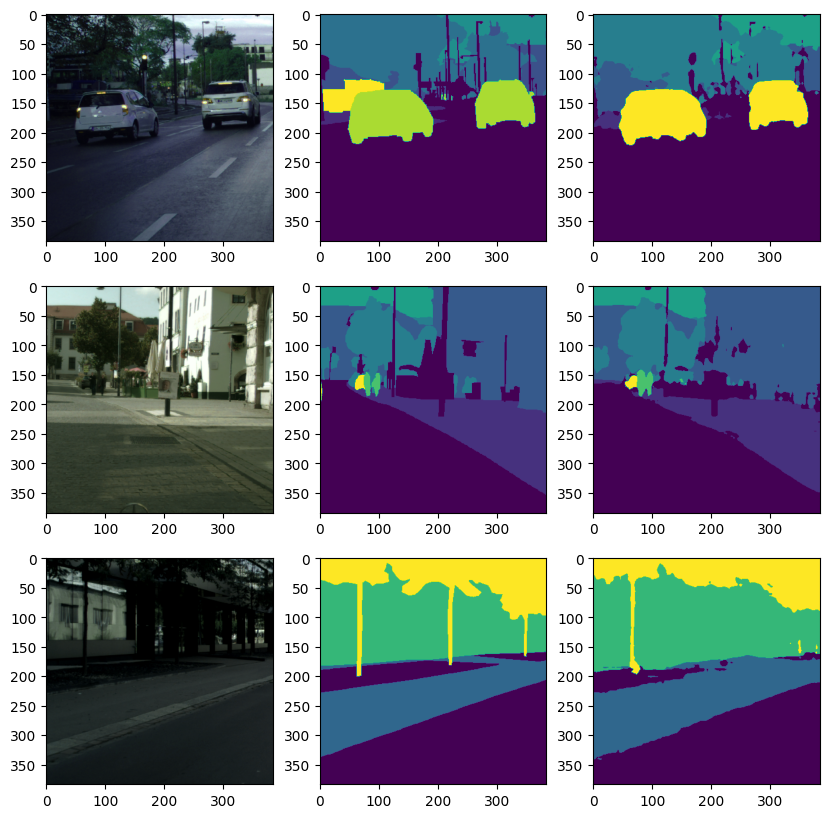

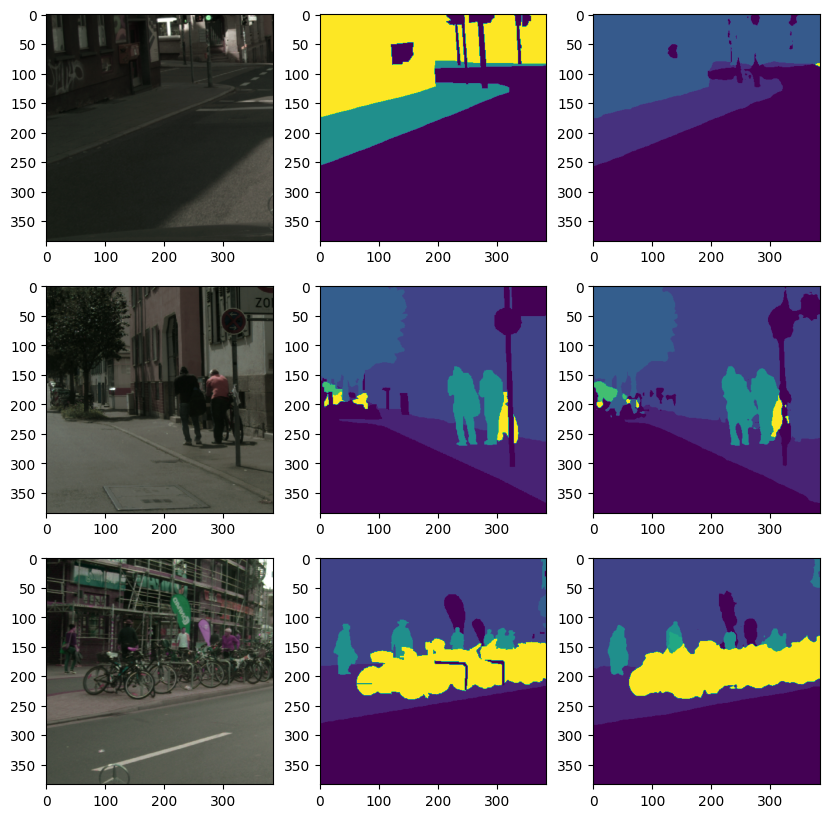

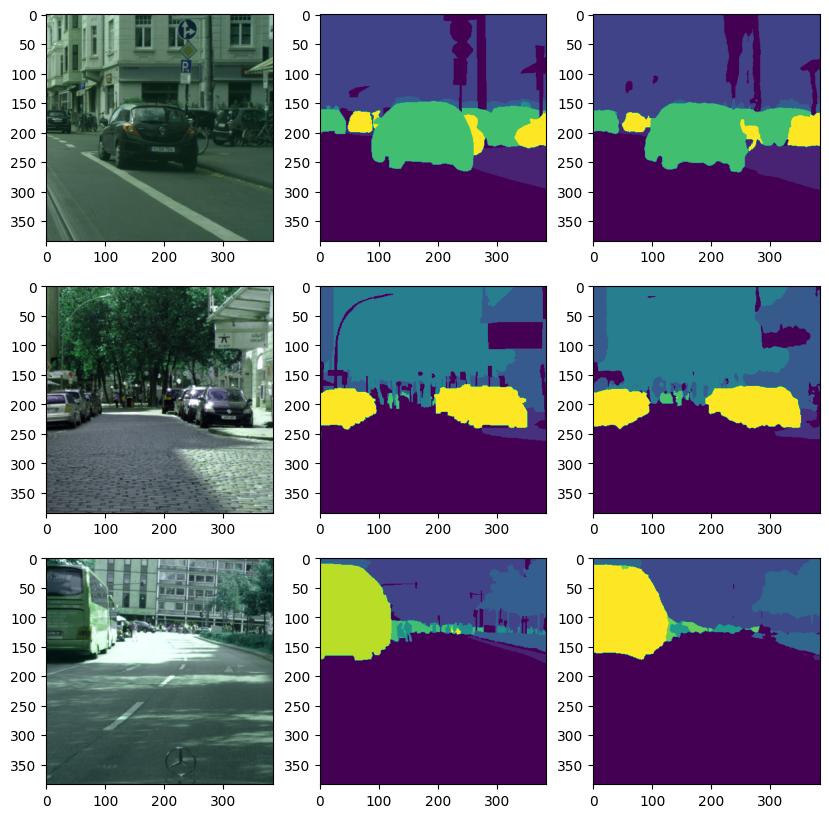

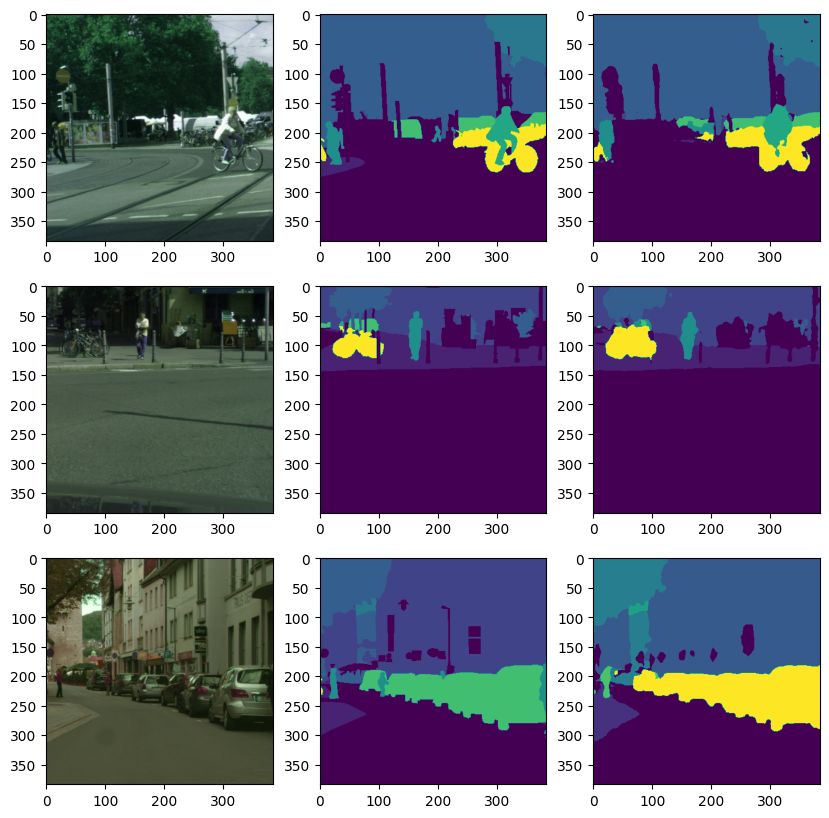

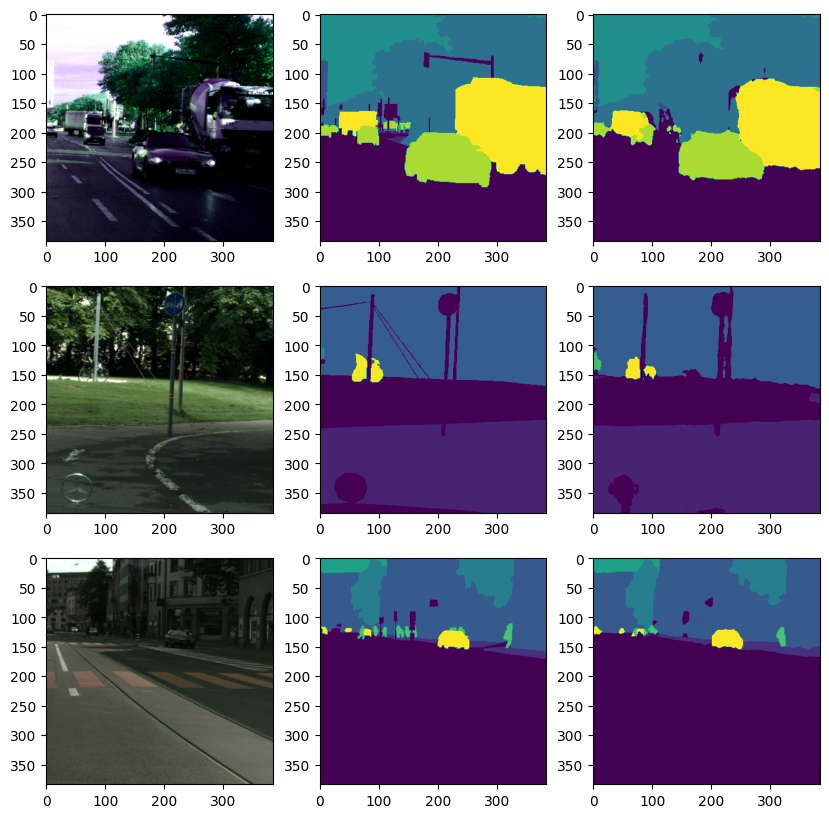

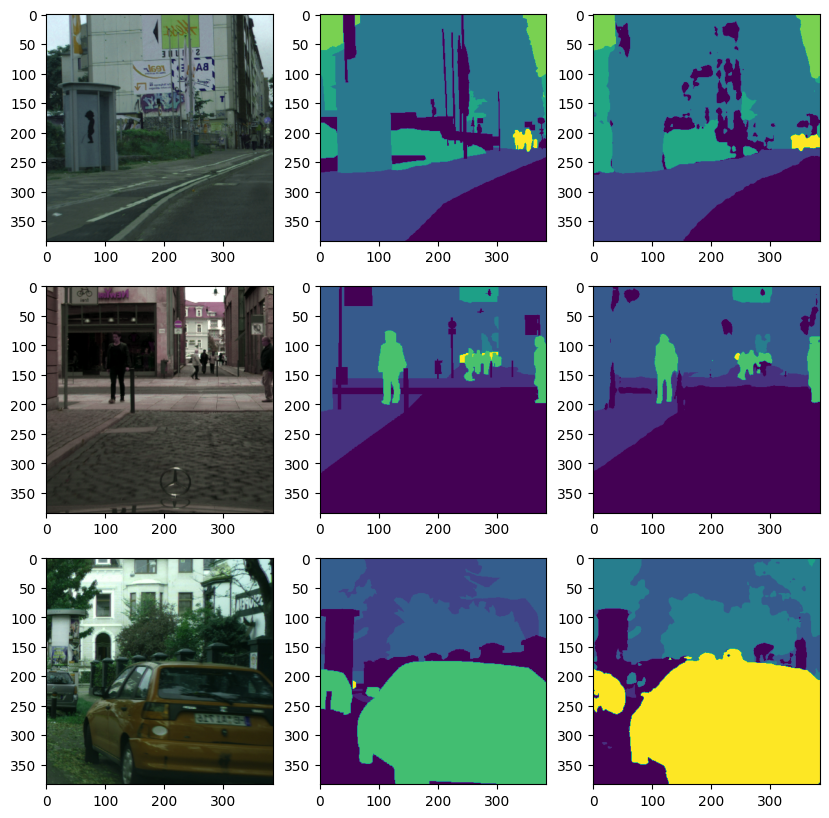

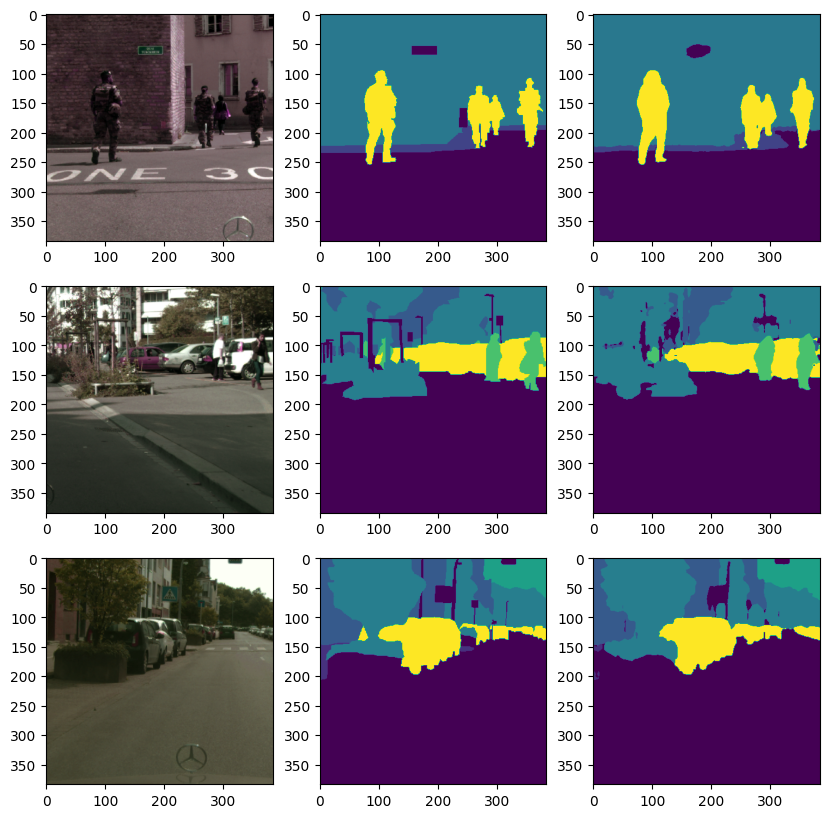

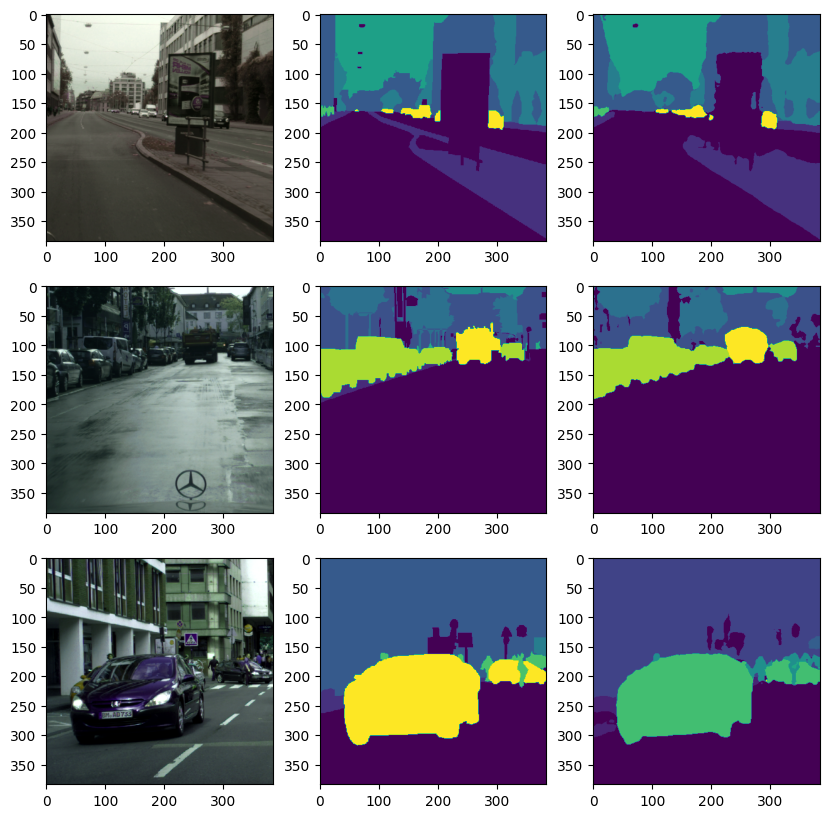

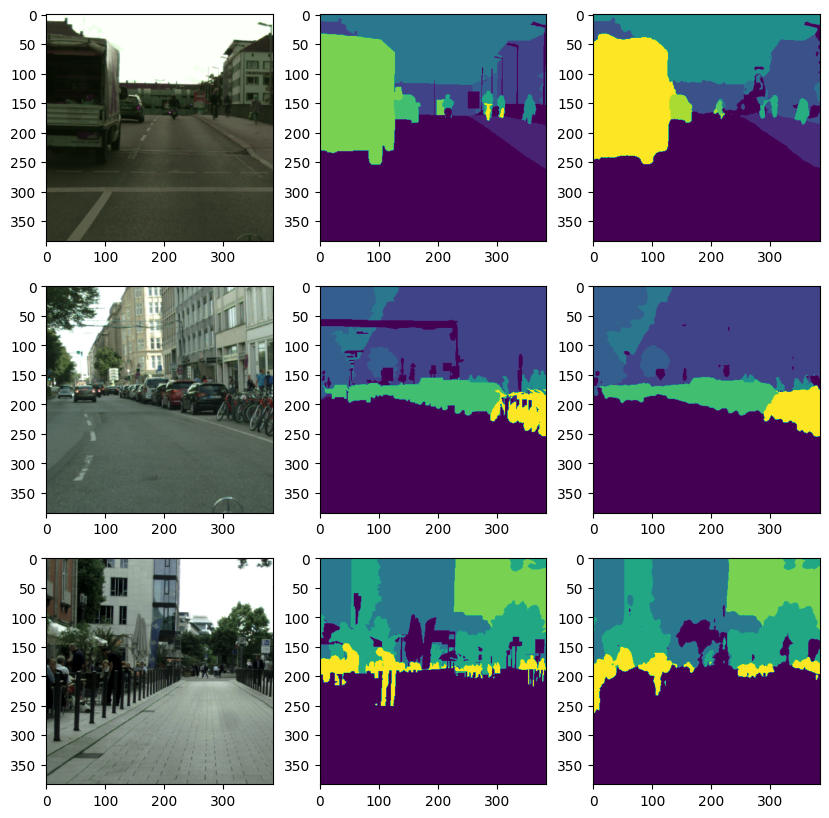

In [18]:
num = 3
for image, mask in dataset_train.take(10):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    miou_metric.update_state(mask, pred_mask)
    accuracy_metric.update_state(mask, pred_mask)
    precision_metric.update_state(mask, pred_mask)
    recall_metric.update_state(mask, pred_mask)

    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))

miou = miou_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()

print("Mean IoU: ", miou)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

In [ ]:
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.metrics import MeanIoU, Accuracy, Precision, Recall

miou_metric = MeanIoU(num_classes=11)
accuracy_metric = Accuracy()
precision_metric = Precision()
recall_metric = Recall()



model.load_weights('path_to_my_weights.h5')

num = 3
for image, mask in dataset_val.take(10):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    miou_metric.update_state(mask, pred_mask)
    accuracy_metric.update_state(mask, pred_mask)
    precision_metric.update_state(mask, pred_mask)
    recall_metric.update_state(mask, pred_mask)

    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))

miou = miou_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()

print("Mean IoU: ", miou)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

In [ ]:
# 绘制训练和测试的损失图
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制训练和测试的准确率图
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 绘制训练和测试的IOU图
plt.subplot(1, 3, 3)
plt.plot(train_ious, label='Train IOU')
plt.plot(test_ious, label='Test IOU')
plt.title('IOU over epochs')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 选择一张图像进行测试
for test_images, test_labels in dataset_val.take(1):  # 假设这里只处理一个批次的数据
    predictions = model(test_images, training=False)  # 获取模型的预测结果
    predictions_crf = []  # 用于存储应用CRF后的结果

    # 将模型的预测结果和原始图像一起传递给CRF函数进行处理
    for i in range(test_images.shape[0]):  # 遍历批次中的每一张图像
        image = test_images[i].numpy()  # 获取原始图像
        pred_prob_map = predictions[i]  # 获取模型对这张图像的预测结果
        pred_prob_map = tf.keras.activations.softmax(pred_prob_map).numpy()  # 确保使用softmax概率

        # 应用CRF优化
        optimized_map = apply_crf(image.astype(np.uint8), pred_prob_map)
        predictions_crf.append(optimized_map)

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU, Accuracy, Precision, Recall

# 加载模型权重
model.load_weights('path_to_my_weights.h5')

# 初始化指标
num_classes = 11
miou_metric = MeanIoU(num_classes=num_classes)
accuracy_metric = Accuracy()
precision_metric = Precision()
recall_metric = Recall()

# 遍历数据集
for image, mask in dataset_val.take(10):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    miou_metric.update_state(mask, pred_mask)
    accuracy_metric.update_state(mask, pred_mask)
    precision_metric.update_state(mask, pred_mask)
    recall_metric.update_state(mask, pred_mask)

# 计算指标
miou = miou_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()

# 获取每个类别的IoU
per_class_iou = miou_metric.get_weights()[0]

# 确保Class IDs和IoU值都是1维的
class_ids = list(range(num_classes))  # 将Class ID转换为列表确保是1维的

# 创建一个Pandas DataFrame来存储每个类别的IoU
metrics_df = pd.DataFrame({
    'Class ID': class_ids + ['Overall'],
    'IoU': list(per_class_iou) + [miou],  # 将per_class_iou转换为列表并添加miou
})

# 打印指标
print(metrics_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

1/1 [==============================] - 0s 142ms/step
   Class ID                                                IoU
0         0  [15853090.0, 226799.0, 313382.0, 177415.0, 717...
1         1  [249153.0, 1275851.0, 7094.0, 3248.0, 0.0, 538...
2         2  [189072.0, 13021.0, 6243311.0, 195717.0, 16229...
3         3  [146202.0, 6809.0, 118927.0, 5821669.0, 15530....
4         4  [4894.0, 0.0, 7274.0, 21698.0, 906671.0, 0.0, ...
5         5  [23957.0, 2696.0, 15267.0, 7473.0, 0.0, 273527...
6         6  [5042.0, 225.0, 3119.0, 2553.0, 0.0, 15090.0, ...
7         7  [47814.0, 1228.0, 14749.0, 10554.0, 0.0, 3666....
8         8  [8447.0, 2.0, 6703.0, 1437.0, 257.0, 436.0, 0....
9         9  [7033.0, 0.0, 2842.0, 3876.0, 0.0, 424.0, 107....
10       10  [19620.0, 3102.0, 9096.0, 3504.0, 0.0, 7956.0,...
11  Overall                                           0.764155
Accuracy: 0.9349842071533203
Precision: 0.9539819359779358
Recall: 0.962439775466919


In [21]:
import numpy as np
import pandas as pd

# 假设已经完成了上述过程，并且miou_metric是最后的MeanIoU对象

# 获取混淆矩阵
confusion_matrix = miou_metric.get_weights()[0]

# 计算每个类别的IoU
ious = []
for i in range(num_classes):
    # 真正阳性（true positive，TP）
    tp = confusion_matrix[i, i]
    # 假正阳性（false positive，FP）和假负阳性（false negative，FN）
    fp = np.sum(confusion_matrix[:, i]) - tp
    fn = np.sum(confusion_matrix[i, :]) - tp
    # 真负阳性（true negative，TN）不用于IoU的计算
    
    iou = tp / (tp + fp + fn + 1e-7)  # 添加一个小数避免除以零
    ious.append(iou)

# 创建一个Pandas DataFrame来显示每个类别的IoU
metrics_df = pd.DataFrame({'Class ID': range(num_classes), 'IoU': ious})

# 计算并添加整体mIoU
miou = np.mean(ious)
metrics_df.loc[num_classes] = ['Overall', miou]

# 打印整体指标
print(metrics_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

   Class ID       IoU
0         0  0.909995
1         1  0.705232
2         2  0.865154
3         3  0.886824
4         4  0.925405
5         5  0.630523
6         6  0.455661
7         7  0.901282
8         8  0.713525
9         9  0.768678
10       10  0.643428
11  Overall  0.764155
Accuracy: 0.9349842071533203
Precision: 0.9539819359779358
Recall: 0.962439775466919


In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix

def pixel_accuracy(confusion_matrix):
    correct_pixels = np.diag(confusion_matrix).sum()
    total_pixels = confusion_matrix.sum()
    return correct_pixels / total_pixels

def class_wise_pixel_accuracy(confusion_matrix):
    class_accuracies = np.diag(confusion_matrix) / confusion_matrix.sum(axis=1)
    return np.nanmean(class_accuracies)

def mean_pixel_accuracy(confusion_matrix):
    return np.diag(confusion_matrix).sum() / confusion_matrix.sum()

def dice_coefficient(confusion_matrix):
    true_positives = np.diag(confusion_matrix)
    false_negatives = np.sum(confusion_matrix, axis=1) - true_positives
    false_positives = np.sum(confusion_matrix, axis=0) - true_positives
    dice = 2 * true_positives / (2 * true_positives + false_positives + false_negatives)
    return np.nanmean(dice)

# 初始化列表以存储真实标签和预测掩码
y_true_list = []
y_pred_list = []

# 遍历验证集，并获取预测结果
for image, mask in dataset_val:
    # 预测
    pred_mask = model.predict(image)
    pred_mask = np.argmax(pred_mask, axis=-1)
    
    # 将真实标签和预测掩码添加到列表中
    y_true_list.extend(np.asarray(mask).flatten())
    y_pred_list.extend(pred_mask.flatten())

# 计算混淆矩阵
num_classes = 11  # 类别数量
cm = confusion_matrix(y_true_list, y_pred_list, labels=range(num_classes))

# 计算各种指标
pa = pixel_accuracy(cm)
cpa = class_wise_pixel_accuracy(cm)
mpa = mean_pixel_accuracy(cm)
dice = dice_coefficient(cm)

print("Pixel Accuracy (PA):", pa)
print("Class-wise Pixel Accuracy (CPA):", cpa)
print("Mean Pixel Accuracy (MPA):", mpa)
print("Dice Coefficient:", dice)

1/1 [==============================] - 0s 133ms/step
Pixel Accuracy (PA): 0.9221055230034723
Class-wise Pixel Accuracy (CPA): 0.8284139498131741
Mean Pixel Accuracy (MPA): 0.9221055230034723
Dice Coefficient: 0.8347633931456498


In [23]:
import numpy as np
from sklearn.metrics import cohen_kappa_score, jaccard_score

# 计算Kappa系数
y_true_list = []
y_pred_list = []

for image, mask in dataset_val:
    pred_mask = model.predict(image)
    pred_mask = np.argmax(pred_mask, axis=-1)
    
    mask = mask.numpy().flatten()
    pred_mask = pred_mask.flatten()
    
    y_true_list.extend(mask)
    y_pred_list.extend(pred_mask)

kappa = cohen_kappa_score(y_true_list, y_pred_list)

# 计算Jaccard相似性系数
jaccard = jaccard_score(y_true_list, y_pred_list, average='macro')

# 计算频权交并比
def frequency_weighted_intersection_over_union(y_true, y_pred):
    intersection = np.histogram2d(y_true, y_pred, bins=(num_classes, num_classes))[0]
    ground_truth_frequency = np.histogram(y_true, bins=num_classes)[0]
    predicted_frequency = np.histogram(y_pred, bins=num_classes)[0]
    union = np.outer(ground_truth_frequency, predicted_frequency)
    union = np.maximum(union, 1)
    iou = intersection / union
    weighted_iou = iou * (ground_truth_frequency / len(y_true))
    frequency_weighted_iou = weighted_iou.sum()
    return frequency_weighted_iou

fw_iou = frequency_weighted_intersection_over_union(y_true_list, y_pred_list)

print("Kappa Score:", kappa)
print("Jaccard Similarity Score:", jaccard)
print("Frequency Weighted Intersection over Union:", fw_iou)

1/1 [==============================] - 0s 123ms/step
Kappa Score: 0.8922607731924982
Jaccard Similarity Score: 0.7212496357205038
Frequency Weighted Intersection over Union: 1.5290007649201948e-07


In [25]:
import time
import tensorflow as tf

# 准备数据集

# 计算模型在验证集上的FPS
total_frames = 0
start_time = time.time()

# 假设dataset_val是一个已经批量处理的数据集
for images, _ in dataset_val:
    # 计时开始前进行一次前向传播，确保不计算模型加载时间
    if total_frames == 0:
        _ = model(images, training=False)
        
    start = time.time()
    _ = model(images, training=False)
    end = time.time()
    
    # 累加处理帧数
    total_frames += images.shape[0]
    print(f"Processed {images.shape[0]} frames in {end - start:.4f} seconds.")

end_time = time.time()
total_time = end_time - start_time

# 计算FPS
fps = total_frames / total_time
print(f"Model FPS on validation dataset: {fps:.2f}")


Processed 24 frames in 0.2023 seconds.
Processed 24 frames in 0.1978 seconds.
Processed 24 frames in 0.1941 seconds.
Processed 24 frames in 0.2089 seconds.
Processed 24 frames in 0.1746 seconds.
Processed 24 frames in 0.2044 seconds.
Processed 24 frames in 0.1552 seconds.
Processed 24 frames in 0.1770 seconds.
Processed 24 frames in 0.1751 seconds.
Processed 24 frames in 0.1839 seconds.
Processed 24 frames in 0.1465 seconds.
Processed 24 frames in 0.2896 seconds.
Processed 24 frames in 0.2941 seconds.
Processed 24 frames in 0.2607 seconds.
Processed 24 frames in 0.1558 seconds.
Processed 24 frames in 0.1682 seconds.
Processed 24 frames in 0.1638 seconds.
Processed 24 frames in 0.2331 seconds.
Processed 24 frames in 0.2542 seconds.
Processed 24 frames in 0.2533 seconds.
Processed 20 frames in 0.1311 seconds.
Model FPS on validation dataset: 63.68
